# SANA: Normalizing the curvature of cortex

Before we quantify the positive pixels classified by the Processor object, we may optionally want to apply an additional step to extract more quantifiable information from our images. In Part2 of example0_prepare_images, we showed how to load a Frame from the WSI using a pseudo-quadrilateral ROI. In this example, we utilize these annotations to deform the image into a normalized cortical space

## Part 0: Setup

Using code from ex0 -- Part2, we load in the annotations and frame

2025-04-29 13:22:49,099 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Loading Frame from .svs slide file...
2025-04-29 13:22:50,955 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Done I/O (1.86 sec)


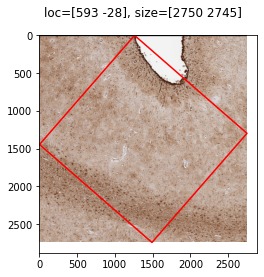

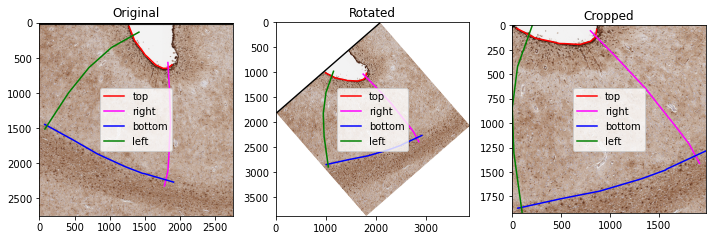

In [ ]:
import os
import geojson
import numpy as np
from matplotlib import pyplot as plt

import pdnl_sana.interpolate
import pdnl_sana.logging
import pdnl_sana.slide
import pdnl_sana as sana


# parses a geojson file
def load_annotations(f, class_name, roi_name=None):
    out = []
    annotations = geojson.load(open(f, 'r'))["features"]
    for annotation in annotations:
        if annotation["properties"]["classification"]["name"] == class_name and (roi_name is None or annotation["properties"]["name"] == roi_name):
            if annotation["geometry"]["type"] == "Polygon":
                x, y = np.array(annotation["geometry"]["coordinates"][0]).T
                out.append(sana.geo.Polygon(x, y, is_micron=False, level=0))
            elif annotation["geometry"]["type"] == "LineString":
                x, y = np.array(annotation["geometry"]["coordinates"]).T
                out.append(sana.geo.Curve(x, y, is_micron=False, level=0))

    return out

SANAPATH = os.path.expanduser('~/sana_builds/main')

# load the segments
f = f'{SANAPATH}/docs/source/resources/example.geojson'
roi_name = "ROI_1"
top = load_annotations(f, "Top", roi_name)[0]
right = load_annotations(f, "Right", roi_name)[0]
bottom = load_annotations(f, "Bottom", roi_name)[0]
left = load_annotations(f, "Left", roi_name)[0]

# prepare to load from the WSI
logger = sana.logging.Logger(debug_level='full', fpath=f'{SANAPATH}/docs/source/resources/example.pkl')
loader = sana.slide.Loader(logger=logger,fname=f'{SANAPATH}/docs/source/resources/example.tif', mpp=0.25225)

# load the ROI and transform the segments into the Frame's coordinate system
frame = loader.load_frame_with_segmentations(top, right, bottom, left, level=0)
top = sana.geo.transform_array_with_logger(top, logger)
right = sana.geo.transform_array_with_logger(right, logger)
bottom = sana.geo.transform_array_with_logger(bottom, logger)
left = sana.geo.transform_array_with_logger(left, logger)


## Part 1: Deforming the cortex

The FanSample method is an interpolation algorithm which uses the 4 segments of the pseudo-quadrilateral. This method works as follows

1) Convert the Left and Right boundaries to nth degree polynomials
2) Sweep the polynomial coefficients to morph the Left polynomial into the Right polynomial
3) At each column, calculate the morphed polynomial and clip at the Top/Bottom boundaries
4) Enter the resulting polynomial into the sampling grid

The result of this algorithm is a sampling grid, which we can use to deform the frame (and any derived images) into a normalized cortical space. This is a rectangular space which allows us to directly compare other sections of cortex that have undergone this same normalization method

The parameters to the method can mostly be left untouched, however there are some specific cases where they need to be changed.

If your segments are more complex, you may consider increasing the polynomial degree to 3. Anything above 3 may result in unexpected behavior

N sets the number of points in the sampling curves, however changing this will do very little to the resulting deformed image and is mostly a plotting parameter

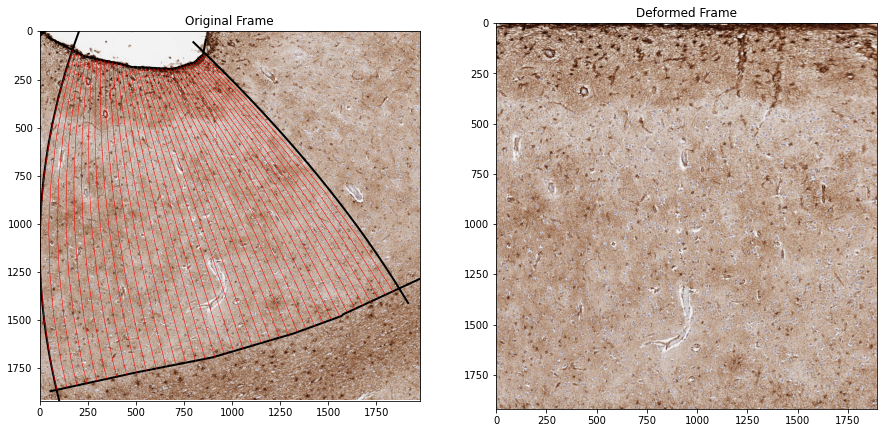

In [3]:
interactive_plots = False
if interactive_plots:
    %matplotlib qt
else:
    %matplotlib inline

fig, axs = plt.subplots(1,2, figsize=(15,10))
axs[0].imshow(frame.img)
    
sample_grid, _ = sana.interpolate.fan_sample(
    top, right, bottom, left, 
    degrees=2, # degree of the polynomial (usually degrees=2 is sufficient)
    N=10, # number of samples in curves
    ax=axs[0], plot_interval=50, # plotting arguments
)
deform = sana.interpolate.grid_sample(frame, sample_grid)

_ = axs[0].set_xlim([0, frame.size()[0]])
_ = axs[0].set_ylim([frame.size()[1], 0])
_ = axs[0].set_title('Original Frame')
_ = axs[1].imshow(deform.img)
_ = axs[1].set_title('Deformed Frame')